# MMMI Oversight Script


**TODO**: Get the agents buying/selling.

**TODO**: What are the macro population statistics, given our concept of macro agents including institutional investors, etc.

**TODO**: Reduce NL logging/warning in the notebook.

In [1]:
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm
from HARK.Calibration.Income.IncomeTools import (
     sabelhaus_song_var_profile,
)

import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import sys

sys.path.append('.')

import hark_portfolio_agents as hpa

In [3]:
sys.path.append('../PNL/py')

import util as UTIL
import pnl as pnl

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Initialize the Simulation

### Initialize market information

Some initial values for the simulation.

$RAP_0$ is the starting risky asset price. This is adjust after every trading day.

In [4]:
risky_asset_price = 100

HARK uses numerical values for wealth. This variable converts "HARK money" to dollars.

In [5]:
dollars_per_hark_money_unit = 1500

Expected rate of return and standard deviation of the market price process will be updated over time.

These are the starting values, derived from the S&P 500.

$\bar{r}_0 = 0.000628$

$sr_0 = 0.011988$

In [6]:
sp500_ror = 0.000628
sp500_std = 0.011988

market_rate_of_return = sp500_ror
market_standard_deviation = sp500_std

Calendar variables. Will ultimately set to be realistic; for now set low for testing.

In [7]:
days_per_quarter = 15
quarters_per_simulation = 6

An attention rate: the chance on any day that an agent will pay attention to the market and trade.

Later, this can be a more realistic function of agent circumstances.

In [8]:
attention_rate = 1 / days_per_quarter

We will need to convert daily price statistics to quarterly price statistics. HARK agents use quarterly (?) statistics. [**Question**: Should HARK agents rebalance knowing how many days are left in the quarter? Or based on a mean number of days between rebalancing periods (based on the attention rate)?]

In [9]:
import math

def ror_quarterly(ror, n_q):
    return pow(1 + ror, n_q) - 1

def sig_quarterly(std, n_q):
    """
     The second formula only holds for special cases (see the attached paper by Andrew Lo), 
     but since we are generating the data we meet this special case.
    """
    return math.sqrt(n_q) * std

### Initialize agents to start

This is to set up the agent parameters and quantities used in the simulation.

`CRRA` refers to the `\rho` parameter in the constant relative risk aversion utility function used by the agents. Utility is over units of resources consumed.

`aNrmInitStd` is normalized initial market assets, standard deviation. The agents' starting wealth is drawn from a lognormal distribution with this standard deviation.

`pLvlInitMean` and `pLvlInitStd` are the mean and standard deviation of the initial level of permanent income of the agents.

In [10]:
## List of tuples: 
##  ( parameters, (i.e. coefficient of relative risk aversion CRRA)
##    number of agents represented,
##    ( initial risky percent, $$$ in risky asset, $$$ in riskless asset)
agent_classes = [
    {
        'CRRA': 2,
        'AgentCount' : 10,
        'aNrmInitMean' : 10
    }] * 10 + \
    [{
        'CRRA': 3, 
        'AgentCount' : 10,
        'aNrmInitMean': 10
    }] * 10 + \
    [{
        'CRRA': 5, 
        'AgentCount' : 10,
        'aNrmInitMean' : 10
    }] * 10 + \
    [{
        'CRRA': 10, 
        'AgentCount' : 10,
        'aNrmInitMean' : 10
    }] * 10 + \
    [{
        'CRRA': 5, 
        'AgentCount' : 10,
        'aNrmInitMean' : 10
    }] * 10


### parameters shared by all agents
agent_parameters = {
    'aNrmInitStd' : 0.0,
    'LivPrb' : [0.98 ** 0.25],
    'PermGroFac': [1.01 ** 0.25],
    'pLvlInitMean' : 1.0, # initial distribution of permanent income
    'pLvlInitStd' : 0.0,
    'Rfree' : 1.0,
    'RiskyAvg': market_rate_of_return,
    'RiskyStd': market_standard_deviation,    
}

Realistic income shock standard deviations from Sabelhaus and Song:

In [11]:
ssvp = sabelhaus_song_var_profile()

# Assume all the agents are 40 for now.
# We will need to make more coherent assumptions about the timing and age of the population later.
# Scaling from annual to quarterly
idx_40 = ssvp['Age'].index(40)

agent_parameters['TranShkStd'] = [ssvp['TranShkStd'][idx_40] ** 0.25] # may not be right for the transitory shock
agent_parameters['PermShkStd'] = [ssvp['PermShkStd'][idx_40] ** 0.25]

In [12]:
len(agent_classes)

50

Initialize the agents.

In [13]:
# This is handling this distribution of discount factors based on cstw_MPC in a hacky way
#      This should be corrected with some HARK updates.
#
#
agents = hpa.create_agents(agent_classes, agent_parameters)

In [14]:
agents[0].state_now

{'pLvl': array([2.83275815, 2.83275815]),
 'PlvlAgg': 1.0,
 'bNrm': array([21136.34081896, 21136.34081896]),
 'mNrm': array([21137.34081896, 21137.34081896]),
 'aNrm': array([8918.25163026, 8918.25163026]),
 'aLvl': array([25263.24998898, 25263.24998898])}

## Get agent risky allocations

Use this stock price to determine the initial number of shares of the risky asset held by each
agent:
 - $RAS_{i0} = (HEC_{i0}.RAW)/ RAP_0$
 
 where RAW is Risky Asset Wealth, amount of resources allocated to the risky asset.
 
 RAS is Risky Asset Shares, number of shares the agent has.

In [15]:
def compute_share_demand(agent):
    agent.solve()
    market_resources = agent.state_now['mNrm']
    permanent_income = agent.state_now['pLvl']
    
    #print("Market Resources: " + str(market_resources))

    # ShareFunc takes normalized market resources as argument
    risky_share = agent.solution[0].ShareFuncAdj(
        market_resources
    )
    
    # denormalize the risky share. See https://github.com/econ-ark/HARK/issues/986
    risky_asset_wealth = risky_share \
                        * market_resources \
                        * permanent_income \
                        * dollars_per_hark_money_unit 
    
    #print("Risky Share: " + str(risky_share))
    #print("Risky Asset Wealth: " + str(risky_asset_wealth))
    
    shares = risky_asset_wealth / risky_asset_price
    
    #print("Shares: " + str(shares))
    
    return shares

In [16]:
for agent in agents:
    agent.shares = compute_share_demand(agent)

## Prepare the main loop

Functions to automate aspects of the main loop.
(Will move this to module code once finalized).

### Data stores

For prices, rates or return, and standard deviations over time.


In [17]:

prices = []
ror_list = []
std_list = []

expected_ror_list = []
expected_std_list = []

buy_sell_list = []

owned_shares_list = []
total_asset_levels_list = []

### Activating agents

"At the beginning of each trading day $t + 1$, select a random group of HARK agents with replacement."

**TODO**: HARK AgentType classes represent multiple agents (as many as `AgentCount`). It is difficult to have the agents within the same AgentType act 'separately', though these agents will have _ex ante_ and _ex post_ heterogeneity of some variables. For the purpose of MMMI, we may need to scaffold the agent model to make it easier to have multiple independently acting agents.

In [18]:
import random

def activate(agents, attention_rate):
    for agent in agents:
        agent.attentive = random.random() < attention_rate

In [19]:
activate(agents, attention_rate)

"**First**, determine the expected return and standard deviation of the risky asset to be used for decision period $t + 1$."

A number of constants used in the calculation of risky expecations.

In [20]:
import math

p1 = 0.1
delta_t1 = 30

a = - math.log(p1) / delta_t1

p2 = 0.1
delta_t2 = 60

b = math.log(p2) / delta_t2

In [21]:
def calculate_risky_expectations():
    # note use of data store lists for time tracking here -- not ideal
    D_t = sum([math.exp(a * l) for l in ror_list])
    S_t = math.exp(b * len(prices))
    
    w_0 = S_t
    w_t = [(1 - S_t) * math.exp(a * (t+1)) / D_t for t in range(len(ror_list))]
    
    expected_ror = w_0 * sp500_ror + sum(
        [w_ror[0] * w_ror[1]
         for w_ror
         in zip(w_t, ror_list)])
    expected_ror_list.append(expected_ror)
    
    expected_std = math.sqrt(
        w_0 * pow(sp500_std, 2) \
        +  sum([w_ror_er[0] * pow(w_ror_er[1] - w_ror_er[2], 2)
                for w_ror_er
                in zip(w_t, ror_list, expected_ror_list)]))
    expected_std_list.append(expected_std)

    # TODO: This should be an adaptive function of market prices
    # as described in John's Experiment design.
    # This is a stopgap for now.
    market_risky_params = {
        'RiskyAvg': ror_quarterly(expected_ror, days_per_quarter),
        'RiskyStd': sig_quarterly(expected_std, days_per_quarter)
    }
    
    return market_risky_params


"**Second**, using [these expectations] calculate the total number of shares of the risky asset that the selected agents want to buy and sell."

In [22]:
def compute_total_buy_sell(agents):
    """
    TODO: Should this be done without making so many changes to the underlying
    agent? Could be done using copies.
    """
    risky_expectations = calculate_risky_expectations()
    
    buy_shares_total = 0
    sell_shares_total = 0
    
    for agent in agents:
        if agent.attentive:
            # Note: this mutates the underlying agent
            agent.assign_parameters(**risky_expectations)
            
            d_shares = compute_share_demand(agent)
            
            delta_shares = d_shares - agent.shares
            
            # NOTE: This mutates the agent
            agent.shares = d_shares
            
            buy_shares_total += delta_shares[delta_shares > 0].sum()
            sell_shares_total += -delta_shares[delta_shares < 0].sum()
            
    return (round(buy_shares_total), round(sell_shares_total))

In [23]:
compute_total_buy_sell(agents)

(0, 0)

"**Third**, using [total buy and sell shares] as input to the Buy Broker and Sell Broker, run a day of NetLogo trading and determine the end of day price of the risky asset."

In [24]:
import os

def run_market(config, buy_sell, seed = None):    
    pnl.run_NLsims(
        config,
        broker_buy_limit = buy_sell[0],
        broker_sell_limit = buy_sell[1],
        SEED = seed,
        use_cache = True
    )

"**Fourth**, use the final price to calculate the amount of wealth each (all) HARK agent has allocated to the risky asset."

In [25]:
def get_transactions(config, seed = 0, buy_sell = (0,0)):
    logfile = pnl.transaction_file_name(config, seed, buy_sell[0], buy_sell[1])
    
    # use run_market() first to create logs
    transactions = pd.read_csv(
        logfile,
        delimiter='\t'
    )
    return transactions

def get_last_simulation_price(config, seed = 0, buy_sell = (0,0)):
    """
    Dividing the output of this by 4
    """
    
    transactions = get_transactions(config, seed=seed, buy_sell = buy_sell)
    prices = transactions['TrdPrice']
    
    return prices[prices.index.values[-1]]

In [26]:
netlogo_ror = -0.00052125
netlogo_std =  0.0068
simulation_price_scale = 0.25

def daily_rate_of_return(config = None, seed = 0, buy_sell = (0, 0)):
    
    last_sim_price = get_last_simulation_price(config, seed=seed, buy_sell = buy_sell)
    
    ror = (last_sim_price * simulation_price_scale - 100) / 100
    
    # adjust to calibrated NetLogo to S&P500
    ror = sp500_std * (ror - netlogo_ror) / netlogo_std + sp500_ror
    
    return ror

In [27]:
def update_agent_wealth(old_share_price, ror):

    new_share_price = old_share_price * (1 + ror)

    for agent in agents:
        market_resources = agent.state_now['mNrm'] * agent.state_now['pLvl']
    
        old_raw = agent.shares * old_share_price
        new_raw = agent.shares * new_share_price
    
        delta_mNrm = (new_raw - old_raw) / \
            (dollars_per_hark_money_unit * agent.state_now['pLvl'])
    
        agent.state_now['mNrm'] = agent.state_now['mNrm'] + delta_mNrm

"Repeat each trading day until the end of the quarter. Then update the economic conditions for each HARK agent (e.g., permanent income level), and repeat [daily loop]."

## Run the main loop



In [30]:
import itertools

seeds = itertools.cycle([0,1,2,3,4])

config = UTIL.read_config(
    config_file = "../PNL/macroliquidity.ini",
    config_local_file = "../PNL/macroliquidity_local.ini"
)

total_asset_levels = sum([agent.state_now['aLvl'].sum() for agent in agents])
print("Total Asset Levels: " + str(total_asset_levels))
total_asset_levels_list.append(total_asset_levels)

# Main loop
for quarter in range(quarters_per_simulation):
    print(f"Q-{quarter}")

    agent_id = 0
    
    for agent in agents:
        agent_id = agent_id + 1
        agent.solve()
        agent.simulate(sim_periods=1)
    
    for day in range(days_per_quarter):
        print(f"Q-{quarter}:D-{day}")
        
        # Set to a number for a fixed seed, or None to rotate
        seed = next(seeds)

        prices.append(risky_asset_price)
        
        activate(agents, attention_rate)
        buy_sell = compute_total_buy_sell(agents)
        print("Buy/Sell Limit: " + str(buy_sell))
        buy_sell_list.append(buy_sell)
        
        run_market(config, buy_sell, seed = seed)
        
        ror =  daily_rate_of_return(config = config, seed = seed, buy_sell = buy_sell)
        print("ror: " + str(ror))
        ror_list.append(ror)
        
        update_agent_wealth(risky_asset_price, ror)
        
        owned_shares = sum([sum(agent.shares) for agent in agents])
        print("Owned: " + str(owned_shares))
        owned_shares_list.append(owned_shares)
        
        total_asset_levels = sum([agent.state_now['aLvl'].sum() for agent in agents])
        print("Total Asset Levels: " + str(total_asset_levels))
        total_asset_levels_list.append(total_asset_levels)
        
        risky_asset_price = risky_asset_price * (1 + ror)

config_file: ../PNL/macroliquidity.ini
config_local_file: ../PNL/macroliquidity_local.ini
Total Asset Levels: 12900170.9198271
Q-0
Q-0:D-0
Buy/Sell Limit: (0, 0)
Output for S:0,BL:0,SL:0 already exists.
Will use cache.
ror: 0.005954286029411765
Owned: 0.0
Total Asset Levels: 5560896.387094105
Q-0:D-1
Buy/Sell Limit: (0, 0)
Output for S:1,BL:0,SL:0 already exists.
Will use cache.
ror: 0.0015469330882352942
Owned: 0.0
Total Asset Levels: 5560896.387094105
Q-0:D-2
Buy/Sell Limit: (0, 0)
Output for S:2,BL:0,SL:0 already exists.
Will use cache.
ror: 0.005954286029411765
Owned: 0.0
Total Asset Levels: 5560896.387094105
Q-0:D-3
Buy/Sell Limit: (0, 0)
Output for S:3,BL:0,SL:0 already exists.
Will use cache.
ror: 0.0015469330882352942
Owned: 0.0
Total Asset Levels: 5560896.387094105
Q-0:D-4
Buy/Sell Limit: (0, 0)
Output for S:4,BL:0,SL:0 already exists.
Will use cache.
ror: 0.005954286029411765
Owned: 0.0
Total Asset Levels: 5560896.387094105
Q-0:D-5
Buy/Sell Limit: (0, 0)
Output for S:0,BL:0,S

Buy/Sell Limit: (0, 0)
Output for S:4,BL:0,SL:0 already exists.
Will use cache.
ror: 0.005954286029411765
Owned: 0.0
Total Asset Levels: 446177.7148299853
Q-3:D-5
Buy/Sell Limit: (0, 0)
Output for S:0,BL:0,SL:0 already exists.
Will use cache.
ror: 0.005954286029411765
Owned: 0.0
Total Asset Levels: 446177.7148299853
Q-3:D-6
Buy/Sell Limit: (0, 0)
Output for S:1,BL:0,SL:0 already exists.
Will use cache.
ror: 0.0015469330882352942
Owned: 0.0
Total Asset Levels: 446177.7148299853
Q-3:D-7
Buy/Sell Limit: (0, 0)
Output for S:2,BL:0,SL:0 already exists.
Will use cache.
ror: 0.005954286029411765
Owned: 0.0
Total Asset Levels: 446177.7148299853
Q-3:D-8
Buy/Sell Limit: (0, 0)
Output for S:3,BL:0,SL:0 already exists.
Will use cache.
ror: 0.0015469330882352942
Owned: 0.0
Total Asset Levels: 446177.7148299853
Q-3:D-9
Buy/Sell Limit: (0, 0)
Output for S:4,BL:0,SL:0 already exists.
Will use cache.
ror: 0.005954286029411765
Owned: 0.0
Total Asset Levels: 446177.7148299853
Q-3:D-10
Buy/Sell Limit: (0,

In [31]:
len(ror_list)

90

In [38]:
data = pd.DataFrame.from_dict({
    't' : range(1 + len(prices)),
    'prices' : [100] + prices,
    'buy' : [None] + [bs[0] for bs in buy_sell_list],
    'sell' : [None]  + [bs[1] for bs in buy_sell_list],
    'owned' : [None] + owned_shares_list,
    'total_assets' : total_asset_levels_list,
    'ror' : [None] + ror_list,
    'expected_ror' : expected_ror_list,
    #'expected_ror_q' : [ror_quarterly(er, days_per_quarter) for er in expected_ror_list],
    'expected_std' : expected_std_list,
    #'expected_std_q' : [sig_quarterly(es, days_per_quarter) for es in expected_std_list],
})


data

,t,prices,buy,sell,owned,total_assets,ror,expected_ror,expected_std
0,0,100.000000,NaN,NaN,NaN,1.290017e+07,NaN,0.000628,0.011988
1,1,100.000000,0.0,0.0,0.0,5.560896e+06,0.005954,0.000604,0.011760
2,2,100.595429,0.0,0.0,0.0,5.560896e+06,0.001547,0.001056,0.011634
3,3,100.751043,0.0,0.0,0.0,5.560896e+06,0.005954,0.001007,0.011393
4,4,101.350944,0.0,0.0,0.0,5.560896e+06,0.001547,0.001284,0.011234
...,...,...,...,...,...,...,...,...,...
86,86,142.664164,0.0,0.0,0.0,8.312304e+04,0.005954,0.437724,2.418209
87,87,143.513628,0.0,0.0,0.0,8.312304e+04,0.001547,0.482366,2.653648
88,88,143.735634,0.0,0.0,0.0,8.312304e+04,0.005954,0.491120,2.940703
89,89,144.591477,0.0,0.0,0.0,8.312304e+04,0.001547,0.542292,3.271025


In [39]:
data.corr()

,t,prices,buy,sell,owned,total_assets,ror,expected_ror,expected_std
t,1.000000,0.998696,NaN,NaN,NaN,-0.818846,0.000000,0.821387,0.713456
prices,0.998696,1.000000,NaN,NaN,NaN,-0.795463,-0.009867,0.846151,0.741478
buy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
owned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_assets,-0.818846,-0.795463,NaN,NaN,NaN,1.000000,0.000000,-0.478538,-0.375469
ror,0.000000,-0.009867,NaN,NaN,NaN,0.000000,1.000000,-0.013096,0.002633
expected_ror,0.821387,0.846151,NaN,NaN,NaN,-0.478538,-0.013096,1.000000,0.979629
expected_std,0.713456,0.741478,NaN,NaN,NaN,-0.375469,0.002633,0.979629,1.000000


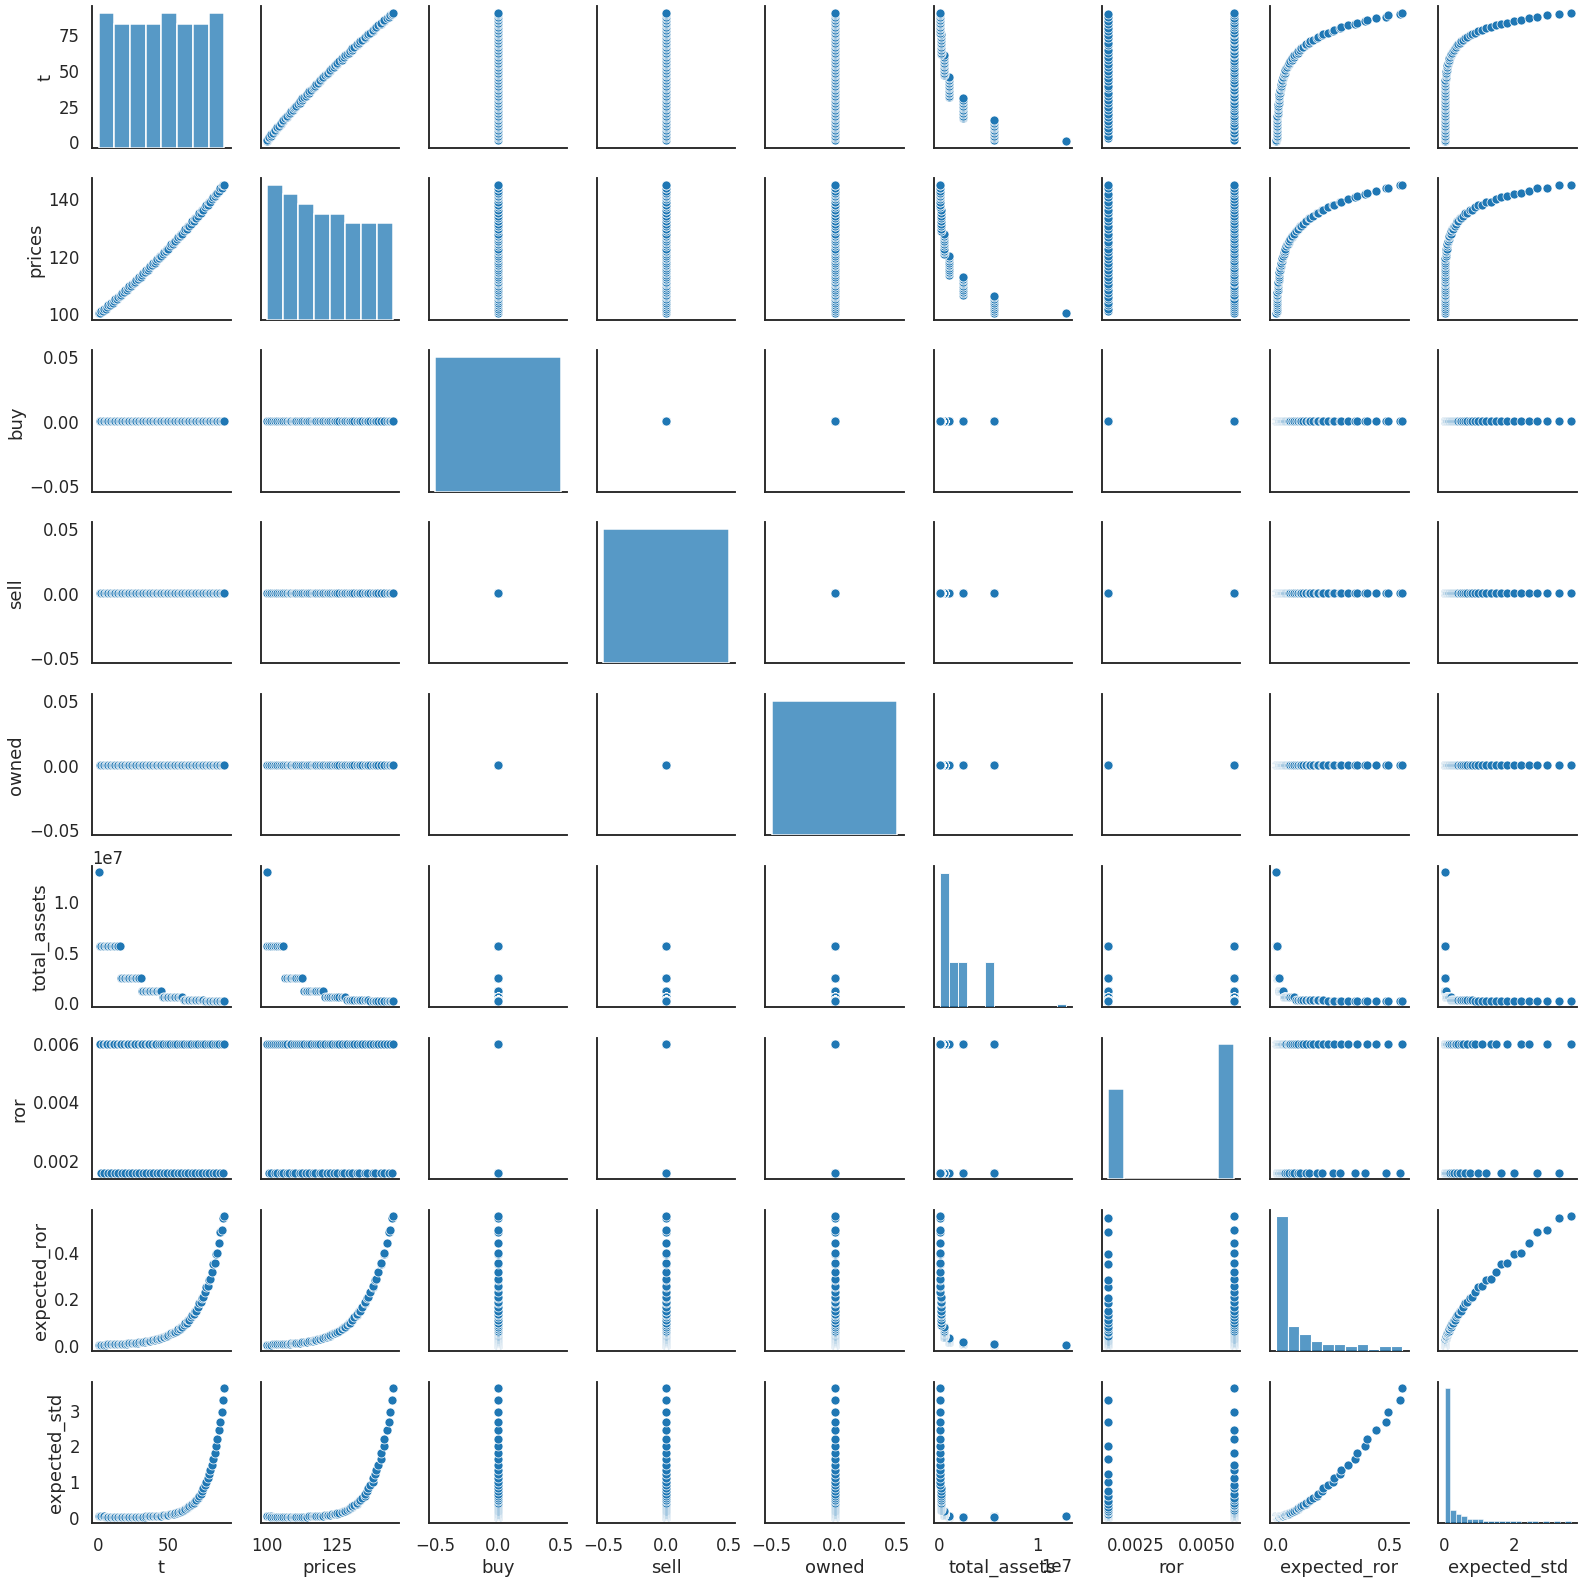

In [40]:
import seaborn as sns

sns.pairplot(data)

In [41]:
data['sell'].max()

0.0

In [42]:
500 / 348


1.4367816091954022

<AxesSubplot:xlabel='t', ylabel='total_assets'>

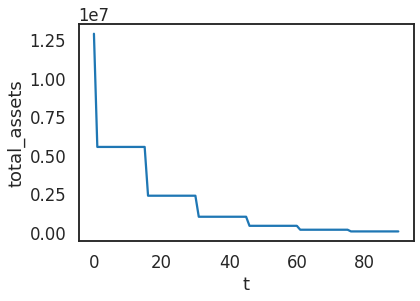

In [45]:
sns.lineplot(data= data, x = 't', y='total_assets')

<AxesSubplot:xlabel='t', ylabel='expected_ror'>

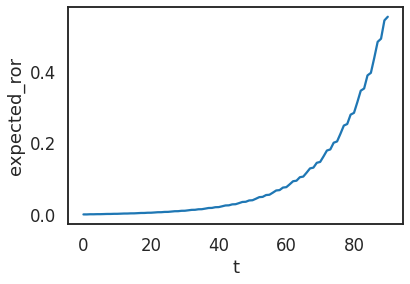

In [43]:
sns.lineplot(data= data, x = 't', y='expected_ror')

<AxesSubplot:xlabel='t', ylabel='expected_std'>

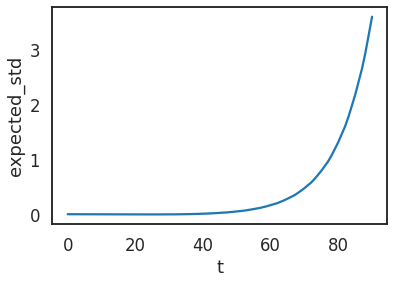

In [44]:
sns.lineplot(data= data, x = 't', y='expected_std')